In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction',
),
    skiprows=1
)

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

class OrderbookEventTypes(IntEnum):
    Limit=1
    PartialCancel=2
    Deletion=3
    ExecutionOfVisibleOrder=4
    ExecutionOfHiddenOrder=5
    TradingHalt=7

class OrderbookIndexes(IntEnum):
    Bid=0
    Ask=1

class OrderbookTypes(IntEnum):
    Limit=0
    Market=1
    Cancel=2

# Remove hidden orderbook events
df = df[
    # (df['type'] != OrderbookEventTypes.ExecutionOfHiddenOrder) & 
    (df['type'] != OrderbookEventTypes.TradingHalt) &
    (df['time'])
    ]

DEPTH = 3
ORDER_TYPES = 3
PRICE_TICK = 100
HALF_PRICE_TICK = PRICE_TICK / 2
NORMALIZED_QUEUE_MAX = 100

In [3]:
midprice = (df['bid1_price'] + df["ask1_price"]) / 2
spread = df["ask1_price"] - df['bid1_price']

spread_conditions = [
    spread == PRICE_TICK,
    df["ask1_size"] >= df['bid1_size'],
    df["ask1_size"] < df['bid1_size']
]

midpoint_leans = [
    midprice,
    midprice + PRICE_TICK,
    midprice - PRICE_TICK
]

df['reference_price'] = np.select(spread_conditions, midpoint_leans)

In [4]:
for n in range(0, DEPTH):
    price_depth = (PRICE_TICK * n) + HALF_PRICE_TICK

    bid_price_level = df['reference_price'] - price_depth
    ask_price_level = df['reference_price'] + price_depth

    bid_conditions = [
        bid_price_level == df['bid1_price'],
        bid_price_level == df['bid2_price'],
        bid_price_level == df['bid3_price'],
        bid_price_level == df['bid4_price'],
        bid_price_level == df['bid5_price'],
    ]
    ask_conditions = [
        ask_price_level == df['ask1_price'],
        ask_price_level == df['ask2_price'],
        ask_price_level == df['ask3_price'],
        ask_price_level == df['ask4_price'],
        ask_price_level == df['ask5_price'],
    ]

    bid_choices = [
        df['bid1_size'],
        df['bid2_size'],
        df['bid3_size'],
        df['bid4_size'],
        df['bid5_size']
    ]
    ask_choices = [
        df['ask1_size'],
        df['ask2_size'],
        df['ask3_size'],
        df['ask4_size'],
        df['ask5_size']
    ]

    df[f'norm_bid{n + 1}_price'] = bid_price_level
    df[f'norm_bid{n + 1}_size'] = np.select(bid_conditions, bid_choices)
    
    df[f'norm_ask{n + 1}_price'] = ask_price_level
    df[f'norm_ask{n + 1}_size'] = np.select(ask_conditions, ask_choices)

display(df)

,time,type,orderId,size,price,direction,ask1_price,ask1_size,bid1_price,bid1_size,...,norm_ask1_price,norm_ask1_size,norm_bid2_price,norm_bid2_size,norm_ask2_price,norm_ask2_size,norm_bid3_price,norm_bid3_size,norm_ask3_price,norm_ask3_size
0,34200.006241,1.0,16114545.0,100.0,275200.0,-1.0,275200,66,275100,400,...,275200.0,66,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
1,34200.006462,1.0,16114695.0,100.0,275500.0,-1.0,275200,166,275100,400,...,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
2,34200.048864,3.0,16063194.0,100.0,275000.0,1.0,275200,166,275100,400,...,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
3,34200.048883,3.0,15833239.0,100.0,275100.0,1.0,275200,166,275100,400,...,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373
4,34200.048989,1.0,16127246.0,100.0,275000.0,1.0,275200,166,275100,300,...,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581024,57599.860444,3.0,287139444.0,34600.0,267200.0,-1.0,267200,122704,267100,7191,...,267200.0,122704,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774
581025,57599.860635,1.0,287166269.0,16600.0,267000.0,1.0,267200,88104,267100,7191,...,267200.0,88104,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774
581026,57599.870108,3.0,287016725.0,600.0,267400.0,-1.0,267200,88104,267100,7191,...,267200.0,88104,267000.0,47783,267300.0,171683,266900.0,28495,267400.0,109774
581027,57599.939645,1.0,287173095.0,100.0,267200.0,-1.0,267200,88104,267100,7191,...,267200.0,88104,267000.0,47783,267300.0,171683,266900.0,28495,267400.0,109174


In [5]:
def getOrdersFromData(dataframe, depth, isBid):
    correctDirection = 1 if isBid else -1
    limitOrder = (dataframe['type'] == 1)
    cancelOrder = (dataframe['type'] == 2) | (dataframe['type'] == 3)
    marketOrderCondititons = (
        (dataframe['type'] == 4) &
        (dataframe[f'norm_bid{depth}_size'] > 0) &
        (dataframe['direction'] == correctDirection)
    )

    return (dataframe[limitOrder], dataframe[cancelOrder], dataframe[marketOrderCondititons])

<BarContainer object of 6 artists>

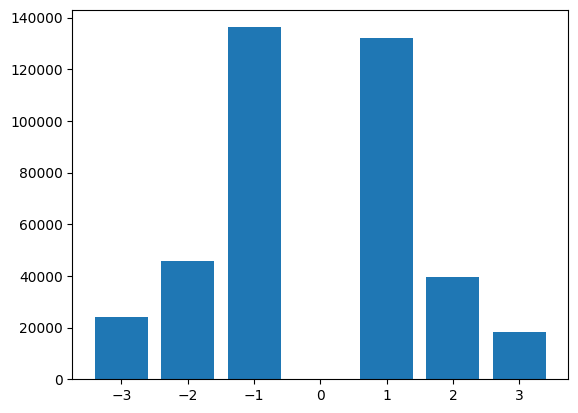

In [6]:
is_event_in_bid = [
    (df['norm_bid1_price'] == df['price']),
    (df['norm_bid2_price'] == df['price']),
    (df['norm_bid3_price'] == df['price']),
]
is_event_in_ask = [
    (df['norm_ask1_price'] == df['price']),
    (df['norm_ask2_price'] == df['price']),
    (df['norm_ask3_price'] == df['price']),
]

data = np.zeros(6)
buckets = [-3, -2, -1, 1, 2, 3]
BID_START_INDEX = 2
ASK_START_INDEX = 3

for price_level in range(0, DEPTH):
    bids_at_depth = df.loc[is_event_in_bid[price_level]]
    asks_at_depth = df.loc[is_event_in_ask[price_level]]

    data[BID_START_INDEX - price_level] = len(bids_at_depth)
    data[ASK_START_INDEX + price_level] = len(asks_at_depth)

plt.bar(buckets, data)

In [7]:
lambdas = np.zeros((DEPTH, 2, ORDER_TYPES, NORMALIZED_QUEUE_MAX))

pd.options.mode.chained_assignment = None  # default='warn'

for price_level in range(0, DEPTH):
    orders_at_depth = df.loc[(is_event_in_bid[price_level]) | (is_event_in_ask[price_level])]
    orders_at_depth['dt_order'] = orders_at_depth['time'].diff().fillna(0)
    
    bids_at_depth = orders_at_depth.loc[is_event_in_bid[price_level]]
    asks_at_depth = orders_at_depth.loc[is_event_in_ask[price_level]]

    average_event_size = (bids_at_depth['size'].mean() + asks_at_depth['size'].mean()) / 2

    bids_at_depth.loc[:, 'queue_length'] = np.ceil(bids_at_depth[f'norm_bid{price_level + 1}_size'].astype(float) / bids_at_depth['size'].mean())
    asks_at_depth.loc[:, 'queue_length'] = np.ceil(asks_at_depth[f'norm_ask{price_level + 1}_size'].astype(float) / asks_at_depth['size'].mean())

    print(f'Price Level {price_level + 1} | AES {average_event_size}')

    for queue_index in range(0, NORMALIZED_QUEUE_MAX):
        bid_queue = bids_at_depth.loc[bids_at_depth['queue_length'] == queue_index]
        ask_queue = asks_at_depth.loc[asks_at_depth['queue_length'] == queue_index]

        bidLimitOrder, bidCancelOrder, bidMarketOrderCondititons  = getOrdersFromData(bid_queue, price_level + 1, True)
        askLimitOrder, askCancelOrder, askMarketOrderCondititons = getOrdersFromData(ask_queue, price_level + 1, False)
        
        numberOfOrdersAtBidQueue = len(bid_queue)
        numberOfOrdersAtAskQueue = len(ask_queue)

        dt_order = orders_at_depth['dt_order'].mean()

        bidLimitIntensity = (len(bidLimitOrder)) / (numberOfOrdersAtBidQueue * dt_order)
        askLimitIntensity = (len(askLimitOrder)) / (numberOfOrdersAtAskQueue * dt_order)

        lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Limit, queue_index] = bidLimitIntensity
        lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Market, queue_index] = len(bidMarketOrderCondititons) / (numberOfOrdersAtBidQueue * dt_order)
        lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Cancel, queue_index] = len(bidCancelOrder) / (numberOfOrdersAtBidQueue * dt_order)

        lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Limit, queue_index] = askLimitIntensity
        lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Market, queue_index] = len(askMarketOrderCondititons) / (numberOfOrdersAtAskQueue * dt_order)
        lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Cancel, queue_index] = len(askCancelOrder) / (numberOfOrdersAtAskQueue * dt_order)
        
    #     if(price_level == 0 and queue_index in [0, 5, 20]):
    #     # if(price_level == 0 and queue_index in [0]):
    #         print(f'[+] Printing information for queue={queue_index}')
        
    #         display(pd.concat([bid_queue, ask_queue]).sort_values(['time']))

    #         print(f"Num of orders | BQ {numberOfOrdersAtBidQueue} | AQ {numberOfOrdersAtAskQueue}")
    #         print(f"Avg. Order delta_t | {dt_order}")        
    # print()

Price Level 1 | AES 421.9725039963913
Price Level 2 | AES 450.90264090506184
Price Level 3 | AES 452.35181793493643


C:\Users\Trevor Semeraro\AppData\Local\Temp\ipykernel_4116\443182702.py:32: RuntimeWarning: invalid value encountered in scalar divide
  askLimitIntensity = (len(askLimitOrder)) / (numberOfOrdersAtAskQueue * dt_order)
C:\Users\Trevor Semeraro\AppData\Local\Temp\ipykernel_4116\443182702.py:39: RuntimeWarning: invalid value encountered in scalar divide
  lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Market, queue_index] = len(askMarketOrderCondititons) / (numberOfOrdersAtAskQueue * dt_order)
C:\Users\Trevor Semeraro\AppData\Local\Temp\ipykernel_4116\443182702.py:40: RuntimeWarning: invalid value encountered in scalar divide
  lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Cancel, queue_index] = len(askCancelOrder) / (numberOfOrdersAtAskQueue * dt_order)


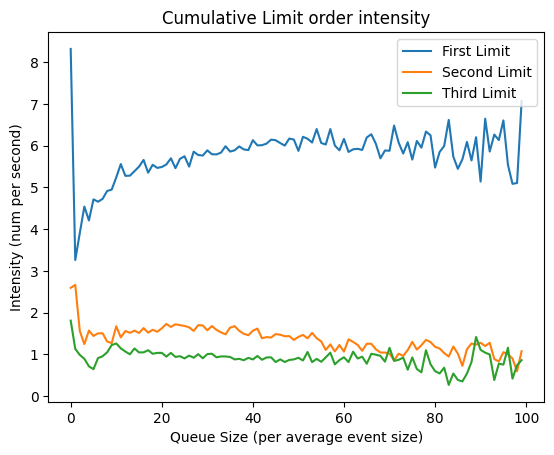

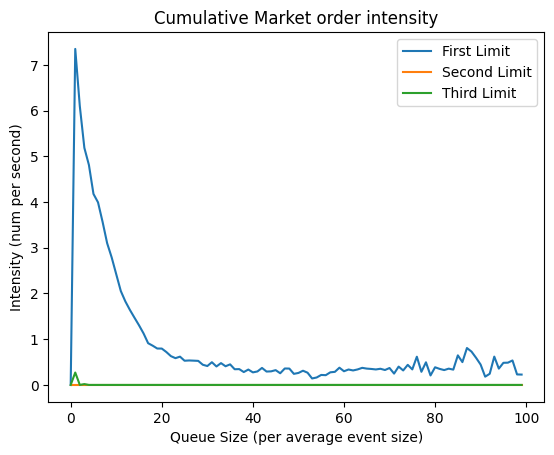

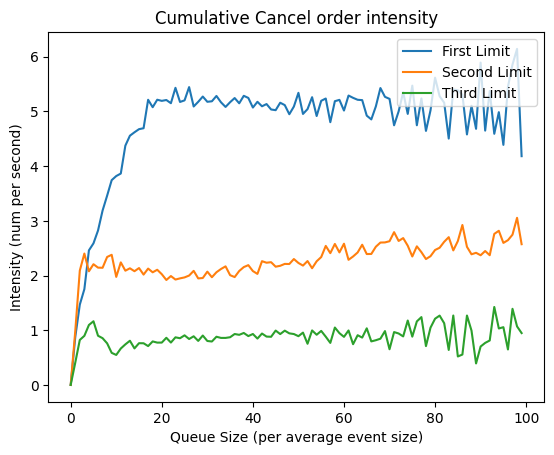

In [8]:
for order_type in OrderbookTypes:
    for x in range(0, 2):
        lambdas[0][x][order_type][np.isnan(lambdas[0][x][order_type])] = 0
        lambdas[1][x][order_type][np.isnan(lambdas[1][x][order_type])] = 0
        lambdas[2][x][order_type][np.isnan(lambdas[2][x][order_type])] = 0

    plt.plot((lambdas[0][OrderbookIndexes.Bid][order_type] + lambdas[0][OrderbookIndexes.Ask][order_type]) / 2, label=f"First Limit")
    plt.plot((lambdas[1][OrderbookIndexes.Bid][order_type] + lambdas[1][OrderbookIndexes.Ask][order_type]) / 2, label=f"Second Limit")
    plt.plot((lambdas[2][OrderbookIndexes.Bid][order_type] +  lambdas[2][OrderbookIndexes.Ask][order_type]) / 2, label=f"Third Limit")
    # plt.plot(lambdas[0][OrderbookIndexes.Bid][order_type], label=f"Bid First Limit")
    # plt.plot(lambdas[1][OrderbookIndexes.Bid][order_type], label=f"Bid Second Limit")
    # plt.plot(lambdas[2][OrderbookIndexes.Bid][order_type], label=f"Bid Third Limit")
    
    # plt.plot(lambdas[0][OrderbookIndexes.Ask][order_type], label=f"Ask First Limit")
    # plt.plot(lambdas[1][OrderbookIndexes.Ask][order_type], label=f"Ask Second Limit")
    # plt.plot(lambdas[2][OrderbookIndexes.Ask][order_type], label=f"Ask Third Limit")

    if (order_type == OrderbookTypes.Limit):
        order_name = "Limit"
    elif (order_type == OrderbookTypes.Market):
        order_name = "Market"
    elif (order_type == OrderbookTypes.Cancel):
        order_name = "Cancel"

    plt.ylabel("Intensity (num per second)")
    plt.xlabel("Queue Size (per average event size)")
    plt.legend(loc='upper right')
    plt.title(f"Cumulative {order_name} order intensity")
    plt.show()

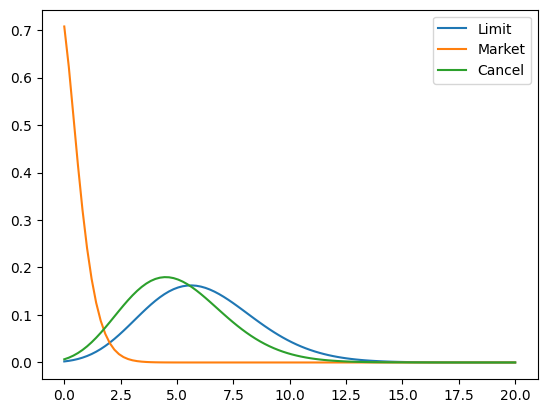

In [9]:
import math

# Poission Distribution
def getPoissonValue(intensity, x):
    return math.pow(intensity, x) * math.pow(math.e, -intensity) / math.gamma(x + 1)

depth = 0
queue_length = 40

# for depth_level in range(0, DEPTH):

intensityLimit = lambdas[depth][OrderbookIndexes.Bid][OrderbookTypes.Limit][queue_length]
intensityMarket = lambdas[depth][OrderbookIndexes.Bid][OrderbookTypes.Market][queue_length]
intensityCancel = lambdas[depth][OrderbookIndexes.Bid][OrderbookTypes.Cancel][queue_length]

x_vals = np.linspace(0, 20, 100)
limit_vals = []
market_vals = []
cancel_vals = []

for x in x_vals:
    limit = getPoissonValue(intensityLimit, x)
    market = getPoissonValue(intensityMarket, x)
    cancel = getPoissonValue(intensityCancel, x)
    limit_vals.append(limit)
    market_vals.append(market)
    cancel_vals.append(cancel)

plt.plot(x_vals, limit_vals, label="Limit")
plt.plot(x_vals, market_vals, label="Market")
plt.plot(x_vals, cancel_vals, label="Cancel")
plt.legend()
plt.show()

In [23]:
# lambdas -> (depth, order_side, order_type, queue_length)
depth = 0
lambdas_df = pd.DataFrame(lambdas[depth][OrderbookIndexes.Bid], index=['Limit', 'Market', 'Cancel'])
lambdas_df1 = pd.DataFrame(lambdas[1][OrderbookIndexes.Bid], index=['Limit', 'Market', 'Cancel'])
lambdas_df2 = pd.DataFrame(lambdas[2][OrderbookIndexes.Bid], index=['Limit', 'Market', 'Cancel'])
display(lambdas_df)
display(lambdas_df1)
display(lambdas_df2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Limit,9.182211,2.809243,3.501878,4.152384,3.856853,4.235902,4.176047,4.504617,4.795900,4.612360,...,5.816434,6.808843,6.151481,6.140603,5.738882,6.483622,5.628519,6.345430,5.391071,6.806581
Market,0.000000,7.894208,6.589496,5.612878,5.289399,4.751355,4.729883,4.084186,3.621512,3.204209,...,0.465315,0.194538,0.150036,0.746055,0.515028,0.175233,0.220726,0.186630,0.000000,0.133462
Cancel,0.000000,0.774312,1.386390,1.712501,2.331511,2.490506,2.571834,2.888961,3.060351,3.661194,...,5.196015,4.474382,5.176246,4.591105,5.223854,4.818908,5.628519,4.945703,6.086693,4.537720


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Limit,2.60289,2.472746,1.424110,1.053700,1.500490,1.178956,1.334948,1.507223,1.119413,1.223358,...,1.062847,0.759176,1.493462,1.414108,1.231790,1.145272,1.121245,1.041156,0.657953,1.275416
Market,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cancel,0.00000,1.171301,2.219936,2.590346,2.143557,2.465090,2.309099,2.136823,2.524633,2.420688,...,2.581200,2.884870,2.150585,2.229939,2.412256,2.498775,2.522801,2.602890,2.986094,2.368630


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Limit,1.805484,1.003047,1.114022,0.722194,0.802437,0.629820,0.815380,0.773779,0.933871,1.227729,...,0.601828,1.289631,0.902742,0.760204,0.644816,0.416650,0.869307,0.526599,0.955844,0.722194
Market,0.000000,0.441341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cancel,0.000000,0.361097,0.691462,1.083290,1.003047,1.175664,0.990104,1.031705,0.871613,0.577755,...,1.203656,0.515853,0.902742,1.045280,1.160668,1.388834,0.936177,1.278884,0.849639,1.083290


In [14]:
np.save("lambdas.npy", lambdas)